### Load Libraries

In [1]:
import os, sys
project_home = "/Users/pitehrhurtado/Documents/OperationResearchs/clustering_and_discretization/src/"
if project_home not in sys.path:
    sys.path = [project_home] + sys.path

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd

from app.aggregations.nearest_pixel import Meta_Pixel

import logging

##### Configs

In [3]:
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [4]:
# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)

### Load Data
#### A. grid data

In [5]:
grid_df = gpd.read_file("../data/geodf.geojson")

In [6]:
grid_df.head(10)

,cell_id,geometry
0,0,"POLYGON ((-68.17297 -16.60097, -68.16360 -16.6..."
1,1,"POLYGON ((-68.16360 -16.60097, -68.15423 -16.6..."
2,2,"POLYGON ((-68.15423 -16.60097, -68.14486 -16.6..."
3,3,"POLYGON ((-68.14486 -16.60097, -68.13549 -16.6..."
4,4,"POLYGON ((-68.13549 -16.60097, -68.12612 -16.6..."
5,5,"POLYGON ((-68.12612 -16.60097, -68.11675 -16.6..."
6,6,"POLYGON ((-68.11675 -16.60097, -68.10738 -16.6..."
7,7,"POLYGON ((-68.10738 -16.60097, -68.09800 -16.6..."
8,8,"POLYGON ((-68.09800 -16.60097, -68.08863 -16.6..."
9,9,"POLYGON ((-68.08863 -16.60097, -68.07926 -16.6..."


#### B. pixel data

In [7]:
df = pd.read_csv("../data/customers_with_layers_v1.csv")

In [8]:
df.head(2)

,year,month,cod_customer,lat,lon,demand,demand_daily,layer,pixel
0,2020,6,807126,-16.495765,-68.121410,1.00,1,0,197.0
1,2022,6,834928,-16.509755,-68.088041,1.56,1,0,185.0


### Description of Layers

In [9]:
from app.plots.plot_grid import Plot_Grid

In [10]:
def plot_by_layer(layer: int, df: pd.DataFrame, geo: gpd.GeoDataFrame, choice = False) -> None:
    """
    """
    df_filtered = df[df.layer == layer].reset_index(drop=True)
    plotter = Plot_Grid(
        grid_geo = geo,
        df = df_filtered,
    )
    logger.info(f"[PLOT-BY-LAYER] Layer {layer} is plotting")
    # n customer per pixel
    if not choice:
        plotter.plot_density_customer()

        # std per pixel
        plotter.plot_grid_by_metric(metric="std")
    
    # mean per pixel
    plotter.plot_grid_by_metric(metric="mean")
    

#### A. Current State

INFO:__main__:[PLOT-BY-LAYER] Layer 0 is plotting
INFO:app.plots.plot_grid:[Plotting Grid] Total pixels: 304 

INFO:app.plots.plot_grid:
[Plotting Grid] Number of pixels with customers: 123 
[Plotting Grid] Number of pixels without customers: 181 

/Users/pitehrhurtado/mambaforge/envs/redesign_network/lib/python3.10/site-packages/geopandas/plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


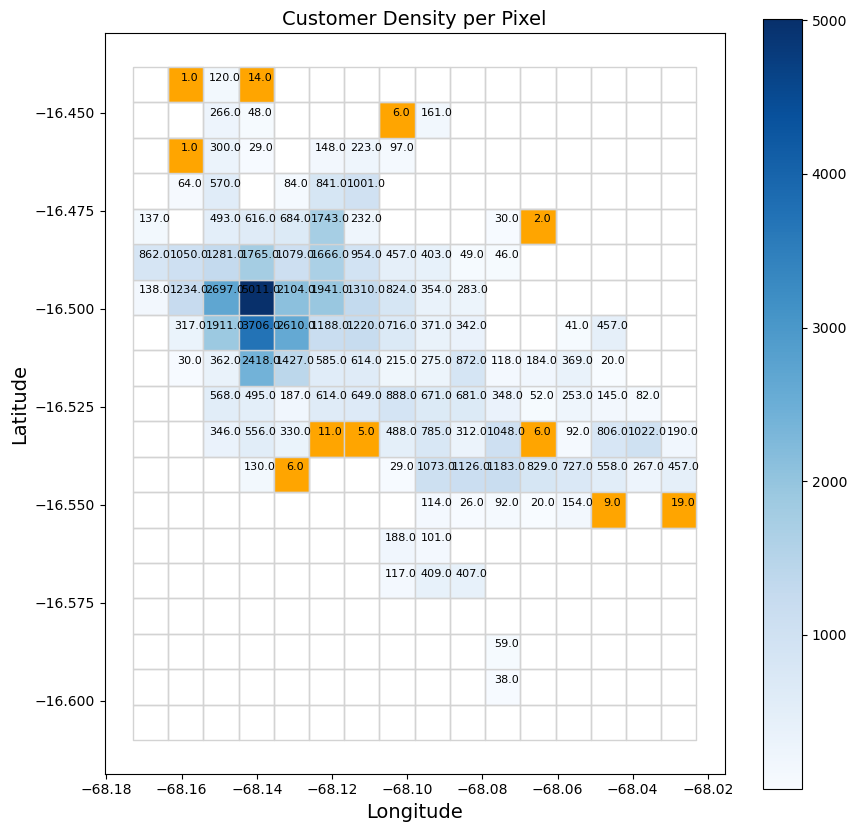

INFO:app.plots.plot_grid:[Plotting Grid] Total pixels: 304 



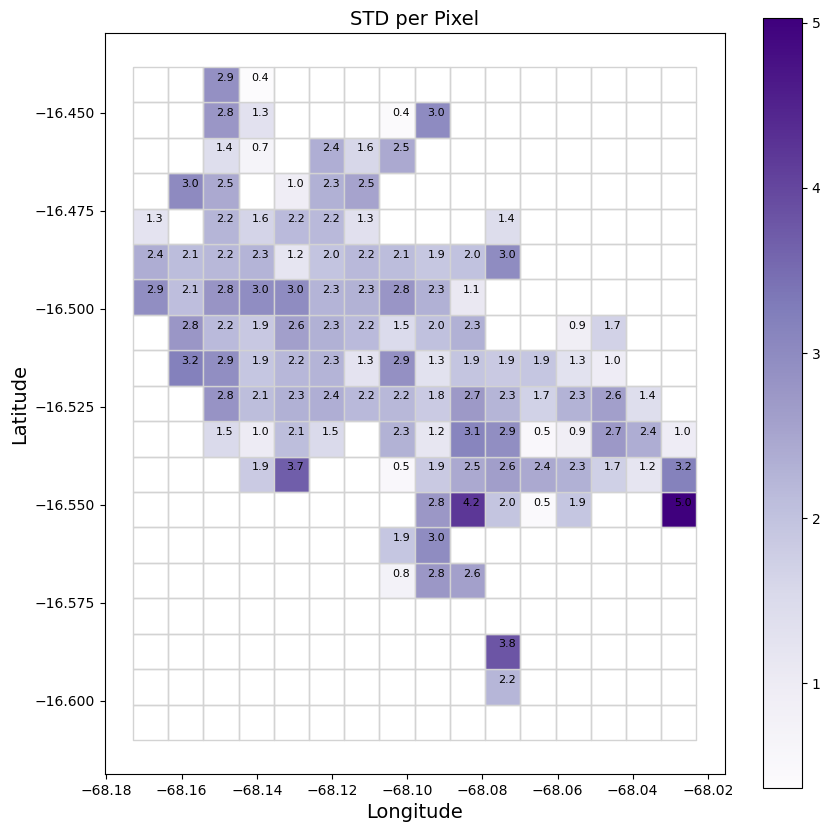

INFO:app.plots.plot_grid:[Plotting Grid] Total pixels: 304 



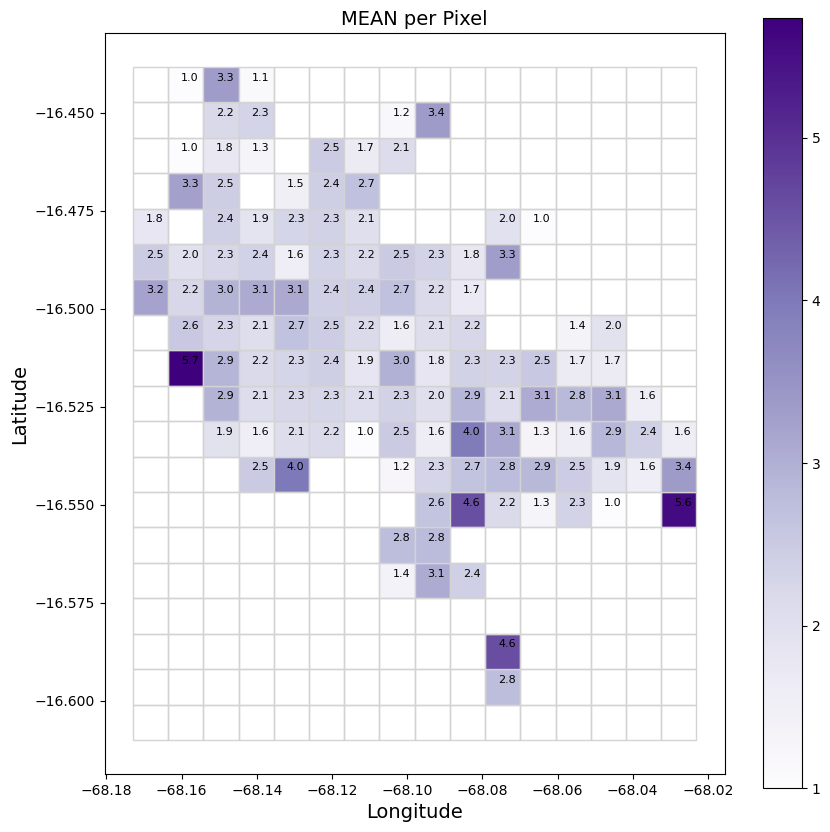

In [11]:
# LAYER 0
plot_by_layer(
    layer=0,
    df=df,
    geo=grid_df,
)

INFO:__main__:[PLOT-BY-LAYER] Layer 1 is plotting
INFO:app.plots.plot_grid:[Plotting Grid] Total pixels: 304 

INFO:app.plots.plot_grid:
[Plotting Grid] Number of pixels with customers: 42 
[Plotting Grid] Number of pixels without customers: 262 

/Users/pitehrhurtado/mambaforge/envs/redesign_network/lib/python3.10/site-packages/geopandas/plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


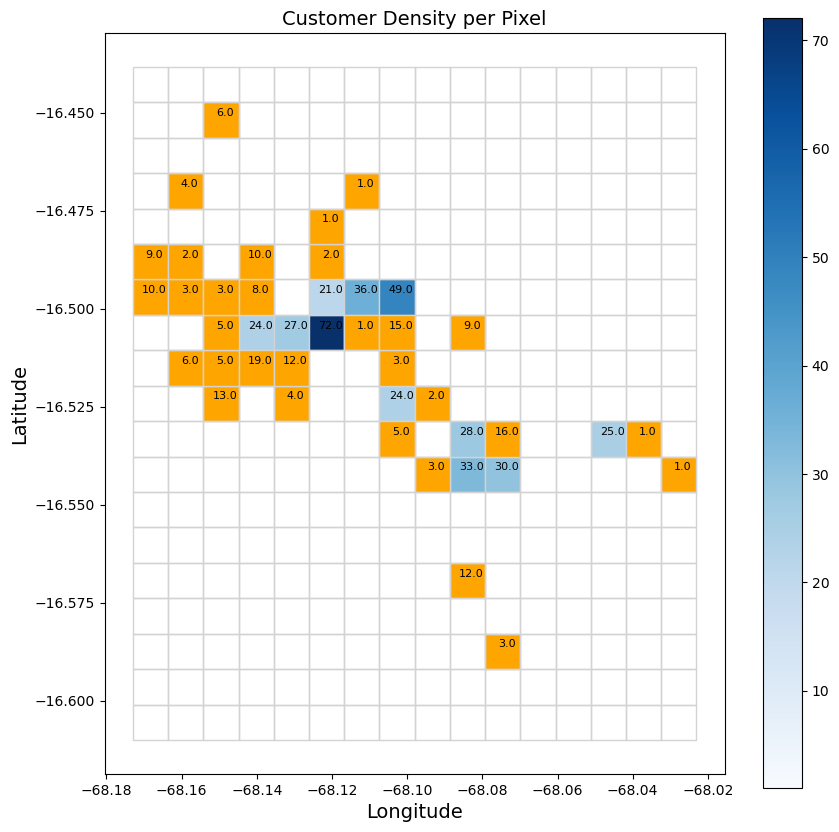

INFO:app.plots.plot_grid:[Plotting Grid] Total pixels: 304 



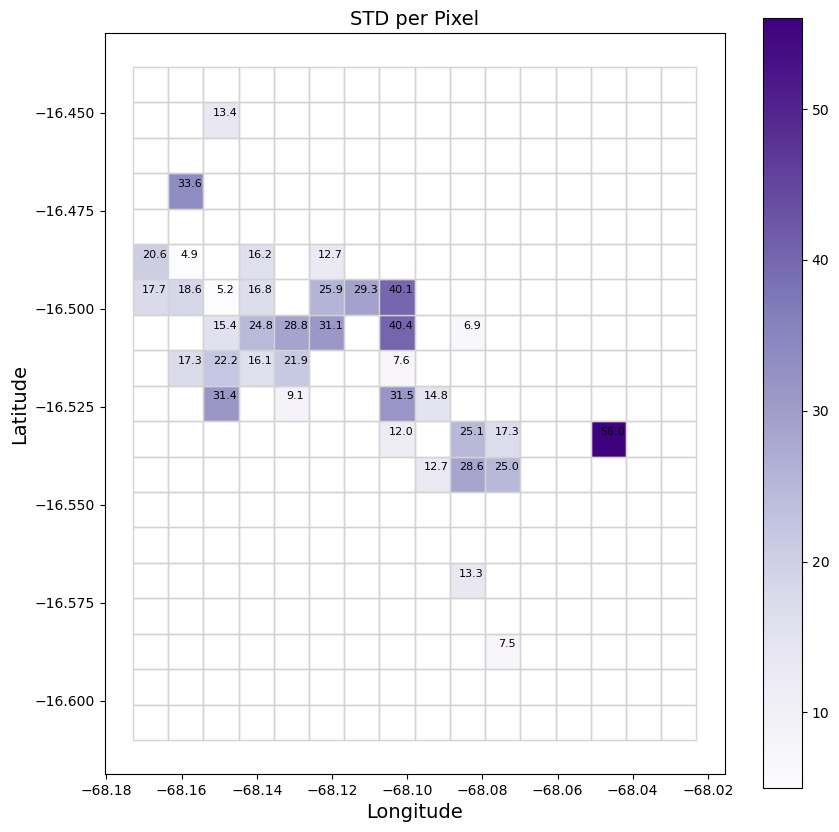

INFO:app.plots.plot_grid:[Plotting Grid] Total pixels: 304 



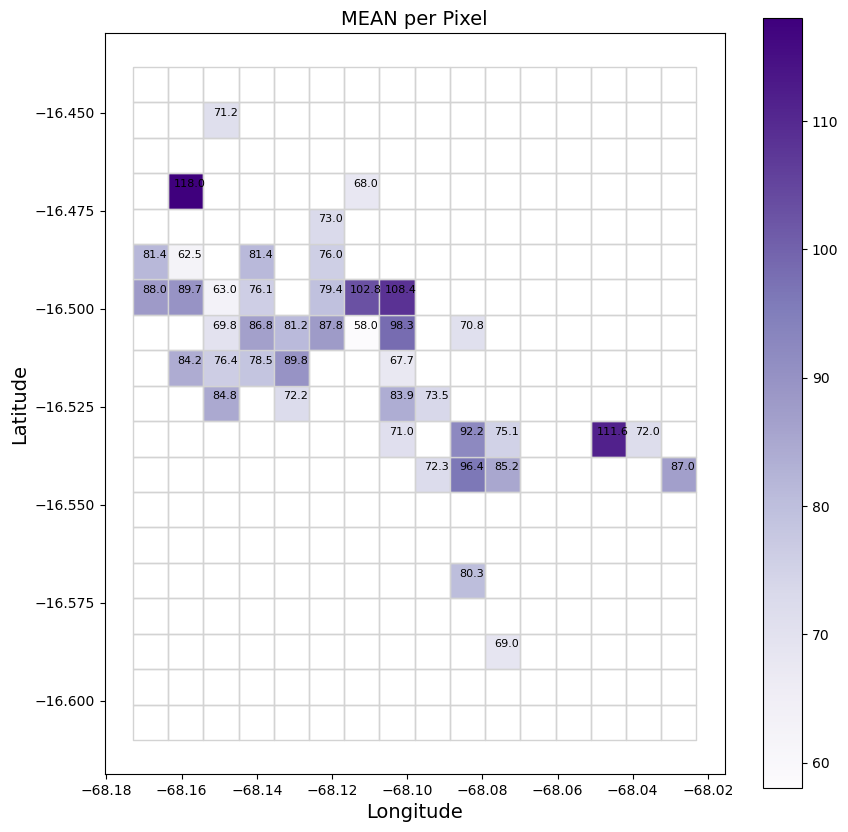

In [12]:
# LAYER 1
plot_by_layer(
    layer=1,
    df=df,
    geo=grid_df,
)

INFO:__main__:[PLOT-BY-LAYER] Layer 2 is plotting
INFO:app.plots.plot_grid:[Plotting Grid] Total pixels: 304 

INFO:app.plots.plot_grid:
[Plotting Grid] Number of pixels with customers: 82 
[Plotting Grid] Number of pixels without customers: 222 

/Users/pitehrhurtado/mambaforge/envs/redesign_network/lib/python3.10/site-packages/geopandas/plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


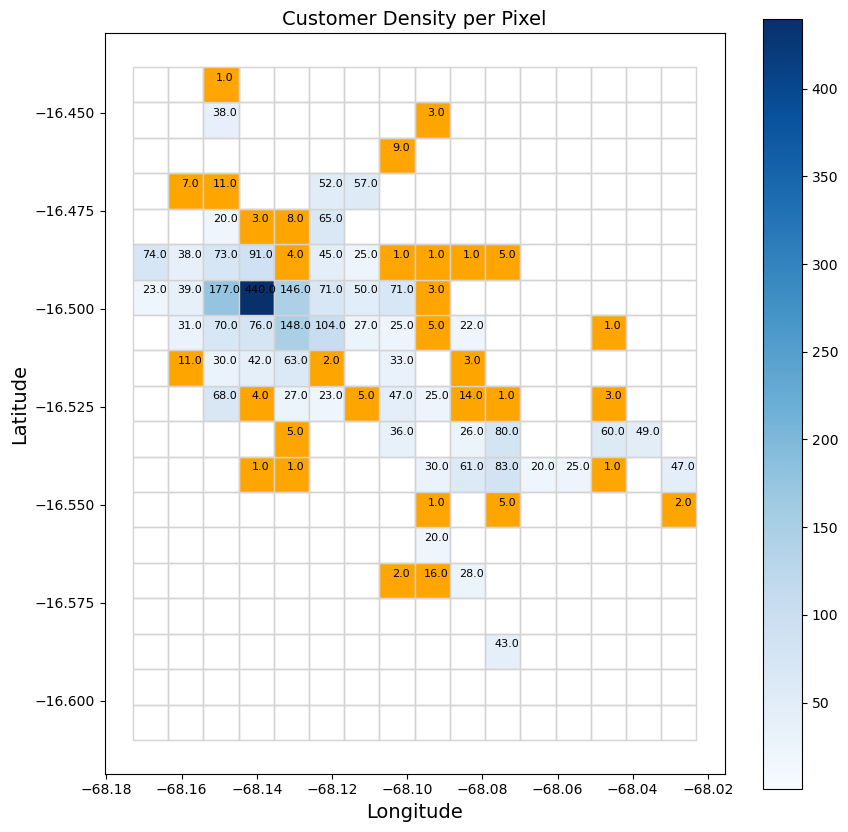

INFO:app.plots.plot_grid:[Plotting Grid] Total pixels: 304 



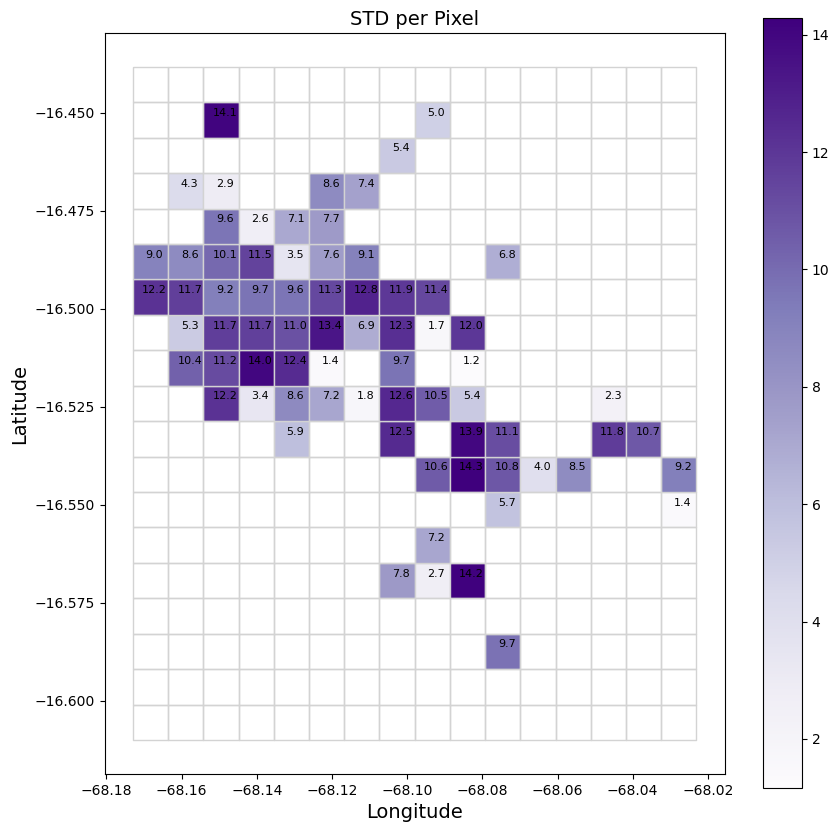

INFO:app.plots.plot_grid:[Plotting Grid] Total pixels: 304 



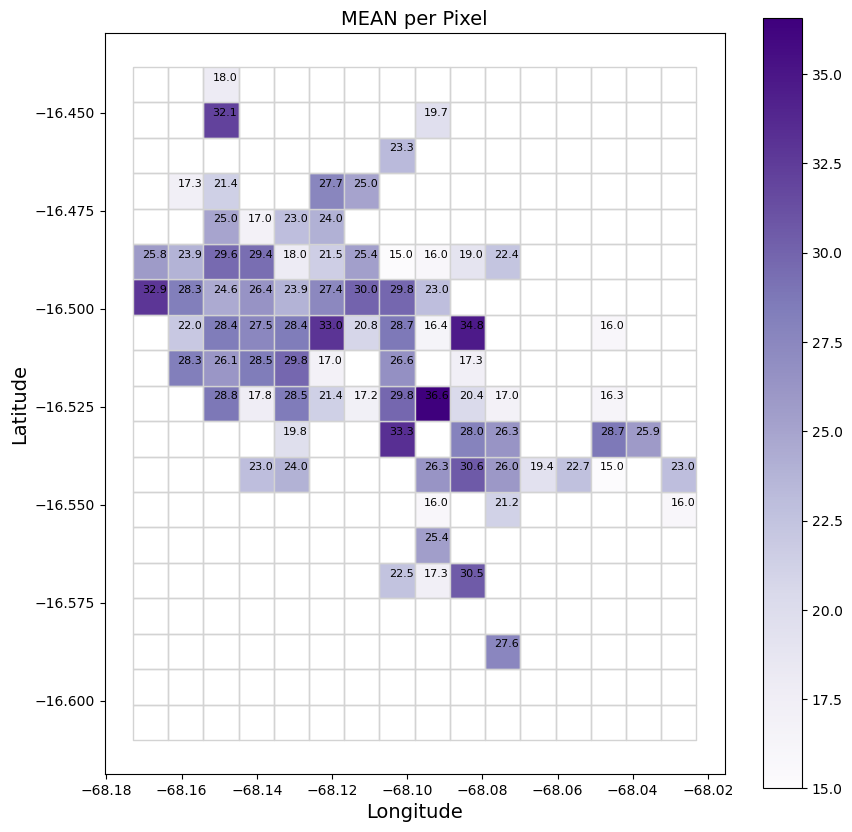

In [13]:
# LAYER 2
plot_by_layer(
    layer=2,
    df=df,
    geo=grid_df,
)

## Aggregation Process

We will use the layer 1 to apply aggregation process

In [14]:
from app.aggregations.nearest_pixel import Meta_Pixel, Pixel
from app.aggregations.utils import set_neighbors

In [15]:
df_used = df[df.layer == 1].reset_index(drop=True)

In [16]:
merged_df = grid_df.merge(df_used,
                         left_on="cell_id",
                         right_on="pixel",
                         how="left")
merged_df["demand_daily"] = merged_df["demand_daily"].fillna(0)
merged_df["pixel"] = merged_df.apply(lambda x: x["pixel"] if not x["pixel"] else x["cell_id"], axis=1)

In [17]:
merged_df.head(1)

,cell_id,geometry,year,month,cod_customer,lat,lon,demand,demand_daily,layer,pixel
0,0,"POLYGON ((-68.17297 -16.60097, -68.16360 -16.6...",NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0


In [18]:
## Create Pixel Object
pixels = {}
for element in merged_df.to_dict(orient="records"):
    if element["pixel"] in pixels:
        pixels[element['pixel']].add_customer(element)
    else:
        init = {
            "id": element["pixel"],
            "corner_down_left": list(element["geometry"].exterior.coords)[3],
            "corner_down_right": list(element["geometry"].exterior.coords)[2],
            "corner_up_right": list(element["geometry"].exterior.coords)[1],
            "corner_up_left": list(element["geometry"].exterior.coords)[0],
            "demand_daily": element["demand_daily"]
        }
        pixels[element['pixel']] = Pixel(init)

In [19]:
## Add set of pixels neighbords / adjacents
### para poder agregar solo pixeles adyacentes
pixels_ = set_neighbors(pixels)

In [20]:
merged_df[merged_df.demand.isna()==False].sort_values(by="pixel")

,cell_id,geometry,year,month,cod_customer,lat,lon,demand,demand_daily,layer,pixel
42,42,"POLYGON ((-68.07926 -16.58290, -68.06989 -16.5...",2021.0,1.0,667951.0,-16.588760,-68.074532,61.08,61.0,1.0,42
43,42,"POLYGON ((-68.07926 -16.58290, -68.06989 -16.5...",2022.0,2.0,667951.0,-16.588760,-68.074532,70.80,70.0,1.0,42
44,42,"POLYGON ((-68.07926 -16.58290, -68.06989 -16.5...",2022.0,12.0,678065.0,-16.588854,-68.074497,76.08,76.0,1.0,42
75,73,"POLYGON ((-68.08863 -16.56483, -68.07926 -16.5...",2021.0,9.0,33494.0,-16.569504,-68.086784,60.72,60.0,1.0,73
76,73,"POLYGON ((-68.08863 -16.56483, -68.07926 -16.5...",2021.0,4.0,33494.0,-16.569504,-68.086784,60.12,60.0,1.0,73
...,...,...,...,...,...,...,...,...,...,...,...
790,274,"POLYGON ((-68.15423 -16.44736, -68.14486 -16.4...",2022.0,2.0,857834.0,-16.448925,-68.145927,58.68,58.0,1.0,274
791,274,"POLYGON ((-68.15423 -16.44736, -68.14486 -16.4...",2020.0,11.0,857834.0,-16.448925,-68.145927,58.20,58.0,1.0,274
792,274,"POLYGON ((-68.15423 -16.44736, -68.14486 -16.4...",2022.0,10.0,857834.0,-16.448925,-68.145927,63.70,63.0,1.0,274
793,274,"POLYGON ((-68.15423 -16.44736, -68.14486 -16.4...",2021.0,8.0,857834.0,-16.448925,-68.145927,75.12,75.0,1.0,274


INFO:__main__:[PLOT-BY-LAYER] Layer 1 is plotting
INFO:app.plots.plot_grid:[Plotting Grid] Total pixels: 304 



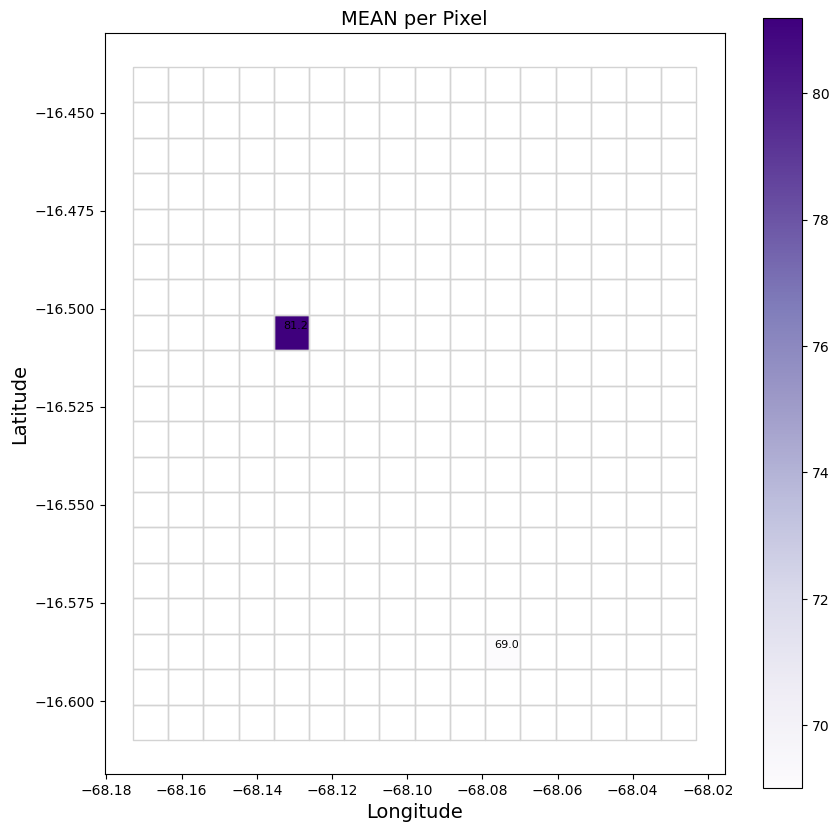

In [21]:
## Ejemplo de construccion de META PIXEL
# tenemos dos pixels, 42 y 180 (ids)
df_aux = merged_df.copy()
df_aux["demand_daily"] = df_aux.apply(lambda x: x["demand_daily"] if x["pixel"] in [42, 180] else 0, axis=1)
# LAYER 1
plot_by_layer(
    layer=1,
    df=df_aux,
    geo=grid_df,
    choice=True,
)

<Axes: >

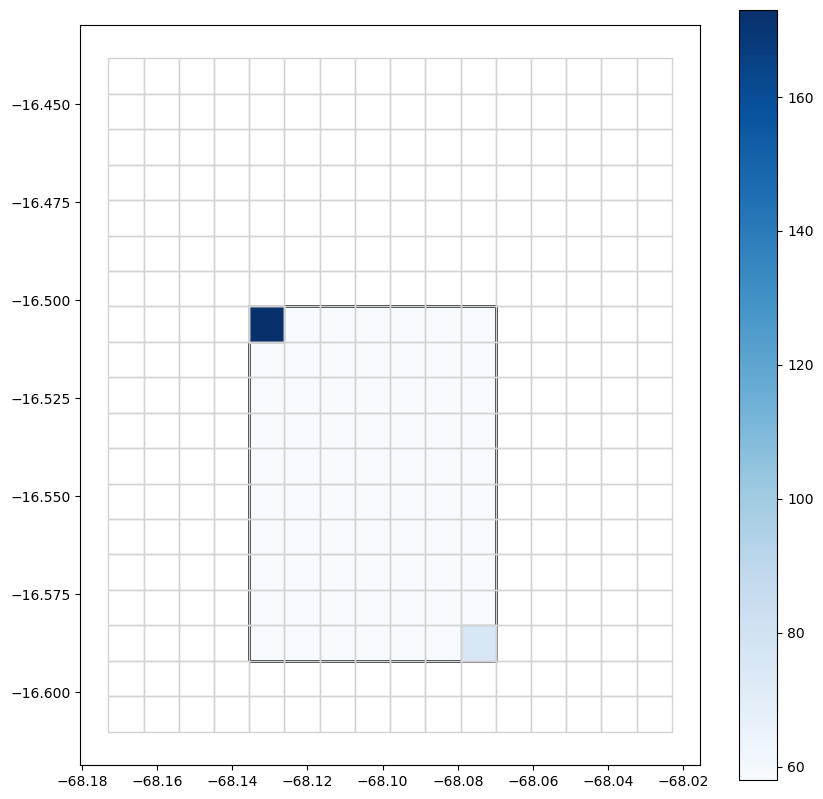

In [22]:
from shapely.geometry import Polygon
from matplotlib import pyplot as plt


# Creamos el Meta Pixel con estos dos
meta_pixel = Meta_Pixel(pixels[42])
meta_pixel.add_pixel(pixels[180])
# computamos las nuevas dimensiones
meta_pixel.construct_meta_pixel()

df_example = gpd.GeoDataFrame(geometry=[meta_pixel.get_polygon()], crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(10,10))
grid_df.boundary.plot(ax=ax, linewidth=1, edgecolor="lightgrey")
df_example.plot(
            ax=ax,
            cmap="Blues",  # o "YlGnBu"
            linewidth=2,
            edgecolor="black",
            legend=True,
        )
df_aux[df_aux.demand_daily > 0].plot(
            ax=ax,
            column="demand_daily",
            cmap="Blues",  # o "YlGnBu"
            linewidth=1,
            edgecolor="lightgrey",
            legend=True,
        )


## Caso Layer 1

In [31]:
def plot_grid_by_metric(metric: str, df_meta_pixels=[], figsize=(10, 10)) -> None:
        """Plot grid with specific metric: mean, std, count, etc"""
        # Calculate std per pixel
        metric_per_pixel = merged_df.groupby("pixel").agg(
            agg_metric=("demand_daily", metric)
        )

        # Join geo data with dataframe-density
        gdf_grid = grid_df.merge(
            metric_per_pixel, left_index=True, right_on="pixel", how="left"
        ).fillna(0)
        logger.info(f"[Plotting Grid] Total pixels: {len(gdf_grid.index)} \n")

        # Split the GeoDataFrame into two: one for zero order density and another for positive order density
        gdf_zero_density = gdf_grid[gdf_grid["agg_metric"] == 0].copy()
        gdf_positive_density = gdf_grid[gdf_grid["agg_metric"] > 0].copy()

        # Create the plot
        fig, ax = plt.subplots(figsize=figsize)

        # Plot the grid cells with zero order density (without fill color)
        gdf_zero_density.boundary.plot(ax=ax, linewidth=1, edgecolor="lightgrey")

        # Plot the grid cells with positive order density (with fill color)
        gdf_positive_density.plot(
            ax=ax,
            column="agg_metric",
            cmap="Purples",  # o "YlGnBu"
            linewidth=1,
            edgecolor="lightgrey",
            legend=True,
        )
        
        # Add meta pixels
        if len(df_meta_pixels)>0:
            df_meta_pixels.plot(
                ax=ax,
                column="std_demand",
                cmap="Purples",  # o "YlGnBu"
                linewidth=3,
                edgecolor="lightgrey",
                legend=True,
            )

        # Add labels to polygons
        for idx, row in gdf_positive_density.iterrows():
            annotation_text = "{:.1f}".format(
                row["agg_metric"]
            )  # Formato con un decimal
            ax.annotate(
                text=annotation_text,
                xy=(row["geometry"].centroid.x, row["geometry"].centroid.y),
                xytext=(3, 3),
                textcoords="offset points",
                ha="center",
                fontsize=8,
            )

        ax.set_xlabel("Longitude", fontsize=14)
        ax.set_ylabel("Latitude", fontsize=14)
        ax.set_title(f"{metric.upper()} per Pixel", fontsize=14)
        plt.show()
        return gdf_positive_density

INFO:__main__:[Plotting Grid] Total pixels: 304 



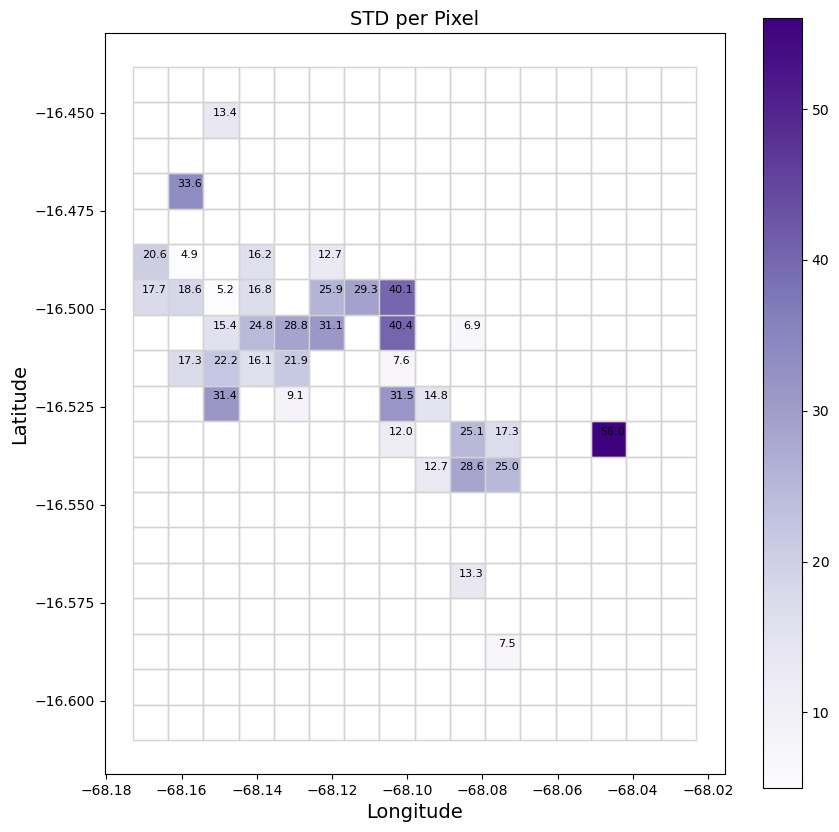

In [32]:
output_df = plot_grid_by_metric("std")

In [33]:
from app.aggregations.algorithms import Aggregation_Pixels
import numpy as np

operator = Aggregation_Pixels(pixels)
list_meta_pixels = operator.run()
list_meta_pixels

output  = []
for e in list_meta_pixels:
    output.append(
        {
            "mean_demand": np.mean(e.demand),
            "std_demand": np.std(e.demand),
            "geometry": e.get_polygon(),
        }
    )

In [34]:
df_meta_pixels = gpd.GeoDataFrame(output, crs="EPSG:4326")
df_meta_pixels

,mean_demand,std_demand,geometry
0,83.625000,18.479296,"POLYGON ((-68.17297 -16.50157, -68.15423 -16.5..."
1,89.900000,30.907766,"POLYGON ((-68.16360 -16.47447, -68.14486 -16.4..."
2,75.000000,17.094166,"POLYGON ((-68.16360 -16.51965, -68.14486 -16.5..."
3,78.066667,12.556362,"POLYGON ((-68.08863 -16.59194, -68.06989 -16.5..."
4,73.884615,14.778693,"POLYGON ((-68.10738 -16.54676, -68.06989 -16.5..."
5,84.896552,31.756992,"POLYGON ((-68.10738 -16.52868, -68.07926 -16.5..."


INFO:__main__:[Plotting Grid] Total pixels: 304 



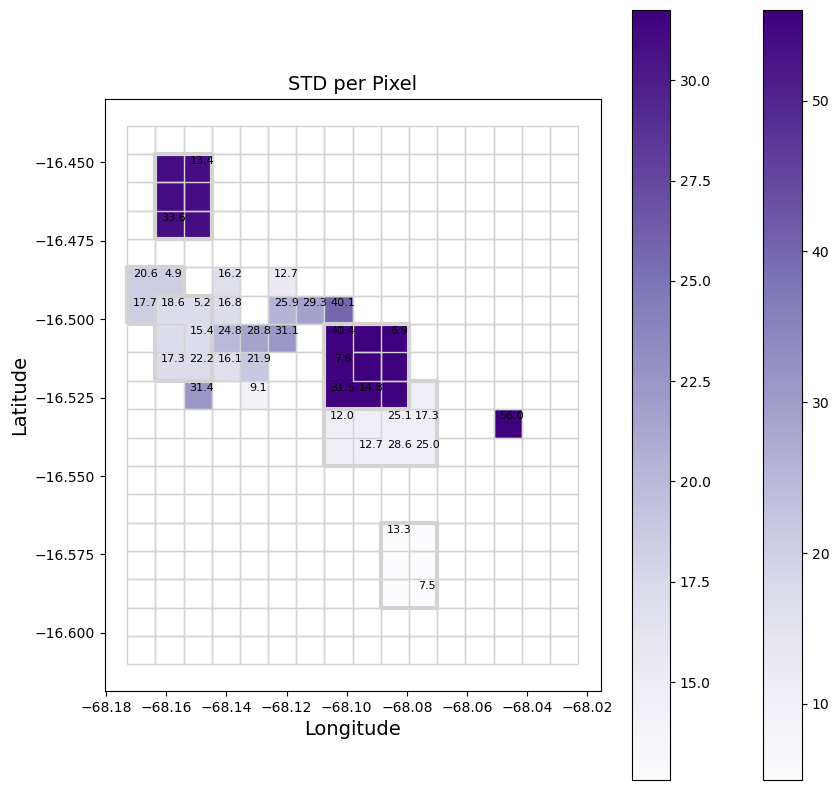

In [42]:
df_output = plot_grid_by_metric("std", df_meta_pixels=df_meta_pixels)

Comentarios:
Los meta pixels se podrian pisar, por lo que visualmente se dificulta

<Axes: >

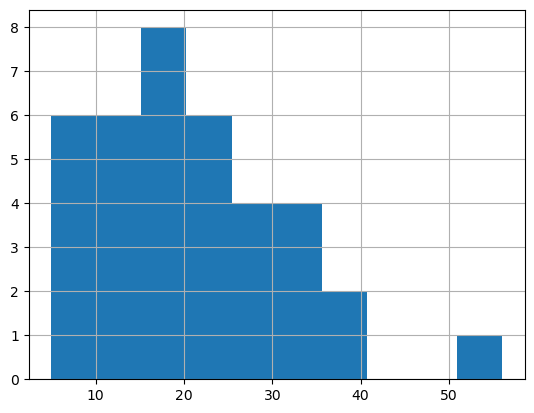

In [43]:
# distribucion de la desviacion estandar ANTES del proceso de agregacion de pixels
output_df["agg_metric"].hist(bins=10)

<Axes: >

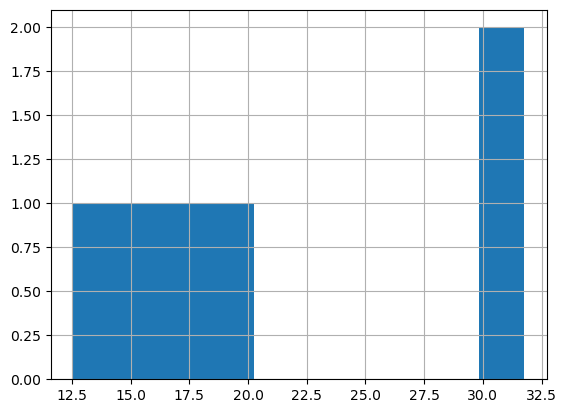

In [44]:
# Distribucion de la desviacion estandar DESPUES del proceso de agregacion de pixels
# podemos observar que algunos grupos generados poseen una MENOR STD que los "peores" pixels

df_meta_pixels["std_demand"].hist(bins=10)